In [75]:
# Load Packages
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd  
import netCDF4
import h5netcdf
import rasterio
from rasterio.plot import show
from pyproj import Transformer
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
from rasterio.warp import reproject, calculate_default_transform
import math
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import box
from scipy.stats import linregress

# Step 1: Calculate low resolution temperature at sea level

In [76]:
# Load the air temperature in low resolution (this data set has the extent that covers the SAFE project)
lowres_temperature = xr.open_dataset('lowres_temperature.nc')
lowres_temperature

<xarray.Dataset> Size: 770kB
Dimensions:    (longitude: 20, latitude: 20, time: 240)
Coordinates:
  * longitude  (longitude) float32 80B 116.0 116.1 116.2 ... 117.7 117.8 117.9
  * latitude   (latitude) float32 80B 5.92 5.82 5.72 5.62 ... 4.22 4.12 4.02
  * time       (time) datetime64[ns] 2kB 2001-01-01 2001-02-01 ... 2020-12-01
Data variables:
    t2m        (time, latitude, longitude) float64 768kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-29 11:40:13 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [77]:
# Load geopotential in low resolution
geopotential_in = xr.open_dataset('lowres_geopotential.nc')
geopotential_in

<xarray.Dataset> Size: 52MB
Dimensions:    (longitude: 3600, latitude: 1801, time: 1)
Coordinates:
  * longitude  (longitude) float32 14kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
  * latitude   (latitude) float32 7kB 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 52MB ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [78]:
# clip geopotential to same extent as temperature
min_lon = 116.0
min_lat = 4.0
max_lon = 118.0
max_lat = 6.0

geopotential = geopotential_in.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
geopotential

<xarray.Dataset> Size: 4kB
Dimensions:    (longitude: 21, latitude: 21, time: 1)
Coordinates:
  * longitude  (longitude) float32 84B 116.0 116.1 116.2 ... 117.8 117.9 118.0
  * latitude   (latitude) float32 84B 6.0 5.9 5.8 5.7 5.6 ... 4.3 4.2 4.1 4.0
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
Data variables:
    z          (time, latitude, longitude) float64 4kB ...
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [79]:
# Interpolate geopotential data onto a lowres_temperature latitude and longitude grid
geopotential= geopotential.interp(
    latitude=lowres_temperature['latitude'],
    longitude=lowres_temperature['longitude'],
    method='linear'  # Select the interpolation method, 'linear' is one of the commonly used interpolation methods
)
geopotential

<xarray.Dataset> Size: 3kB
Dimensions:    (time: 1, latitude: 20, longitude: 20)
Coordinates:
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
  * latitude   (latitude) float32 80B 5.92 5.82 5.72 5.62 ... 4.22 4.12 4.02
  * longitude  (longitude) float32 80B 116.0 116.1 116.2 ... 117.7 117.8 117.9
Data variables:
    z          (time, latitude, longitude) float64 3kB -110.5 ... 74.56
Attributes:
    Conventions:               CF-1.6
    history:                   Fri Jun 12 14:41:56 2020: ncpdq -U geo_1279l4_...
    NCO:                       4.7.2
    nco_openmp_thread_number:  1

In [80]:
# Convert geopotential to altitude
gravity = 9.81
earth_radius = 6371000 # in meters
altitude = (geopotential * earth_radius) / (gravity * earth_radius - geopotential)
altitude

<xarray.Dataset> Size: 3kB
Dimensions:    (time: 1, latitude: 20, longitude: 20)
Coordinates:
  * time       (time) datetime64[ns] 8B 2013-08-09T12:00:00
  * latitude   (latitude) float32 80B 5.92 5.82 5.72 5.62 ... 4.22 4.12 4.02
  * longitude  (longitude) float32 80B 116.0 116.1 116.2 ... 117.7 117.8 117.9
Data variables:
    z          (time, latitude, longitude) float64 3kB -11.26 123.9 ... 7.601

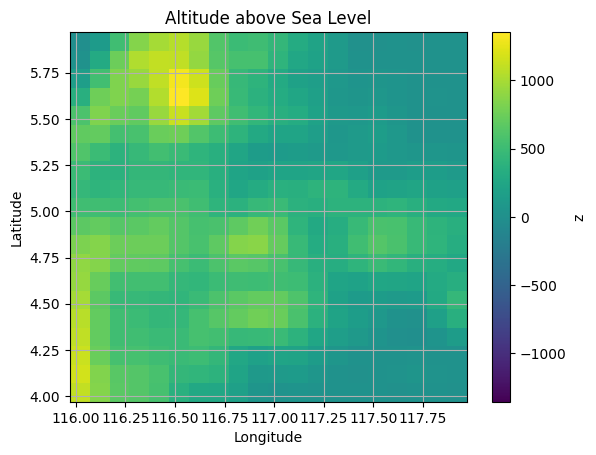

In [81]:
# plot altitude above Sea Level
altitude['z'].plot(cmap='viridis')

plt.title('Altitude above Sea Level')  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.grid(True)  

plt.show()

In [82]:
# Adjust low resolution temperature to mean sea level
# Specify the lapse rate (-0.006 K m^-1)
lapse_rate = -0.006

lowres_temperature_sealevel = lowres_temperature['t2m'].values - (altitude['z'].values * lapse_rate)
lowres_temperature_sealevel = xr.DataArray(
    lowres_temperature_sealevel,
    dims=['time','longitude','latitude'],
    coords={
        'time': lowres_temperature.time,
        'longitude': lowres_temperature.longitude,
        'latitude': lowres_temperature.latitude,
    }
)
lowres_temperature_sealevel

<xarray.DataArray (time: 240, longitude: 20, latitude: 20)> Size: 768kB
array([[[         nan, 298.65411633, 299.41389372, ..., 298.40276789,
         298.50393161, 298.60633604],
        [         nan, 298.69287835, 299.59928575, ..., 298.37149762,
         298.4587706 , 298.49432702],
        [298.6933379 , 299.12651356, 299.56206743, ..., 298.3448078 ,
         298.43417772, 298.42375612],
        ...,
        [299.91456804, 299.22067472, 298.83217681, ..., 298.67114509,
         298.82309443,          nan],
        [299.9634416 , 299.35274445, 298.90178761, ..., 298.89914704,
         299.01735991, 299.12817532],
        [299.61212763, 299.25354414, 298.92178718, ...,          nan,
                  nan,          nan]],

       [[         nan, 298.64159698, 299.35954143, ..., 298.60048198,
         298.72073007, 298.83183698],
        [         nan, 298.69409974, 299.50676472, ..., 298.56783764,
         298.63251472, 298.65402504],
        [298.6872309 , 299.09857404, 299.46405009, ..., 298.53137662,
         298.60746382, 298.58818707],
...
        [300.47702264, 299.68740211, 299.24791076, ..., 299.27848614,
         299.45303137,          nan],
        [300.49765133, 299.83977762, 299.37904958, ..., 299.59519224,
         299.72302363, 299.86116787],
        [300.16420033, 299.77126497, 299.46637881, ...,          nan,
                  nan,          nan]],

       [[         nan, 299.1081717 , 299.6812276 , ..., 299.41179679,
         299.50563211, 299.53765338],
        [         nan, 299.0676954 , 299.85608506, ..., 299.37625162,
         299.43695916, 299.43037728],
        [299.16510357, 299.45171125, 299.72130742, ..., 299.30742351,
         299.38320536, 299.37125701],
        ...,
        [300.48557244, 299.65915724, 299.20027617, ..., 299.28474581,
         299.4595964 ,          nan],
        [300.51826245, 299.82435744, 299.33233104, ..., 299.60084122,
         299.72607713, 299.82712135],
        [300.17992585, 299.74989048, 299.41172117, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-01 2001-02-01 ... 2020-12-01
  * longitude  (longitude) float32 80B 116.0 116.1 116.2 ... 117.7 117.8 117.9
  * latitude   (latitude) float32 80B 5.92 5.82 5.72 5.62 ... 4.22 4.12 4.02

/var/folders/vq/91h3xwfn35s185lcs4zf91x80000gn/T/ipykernel_19993/1193115438.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


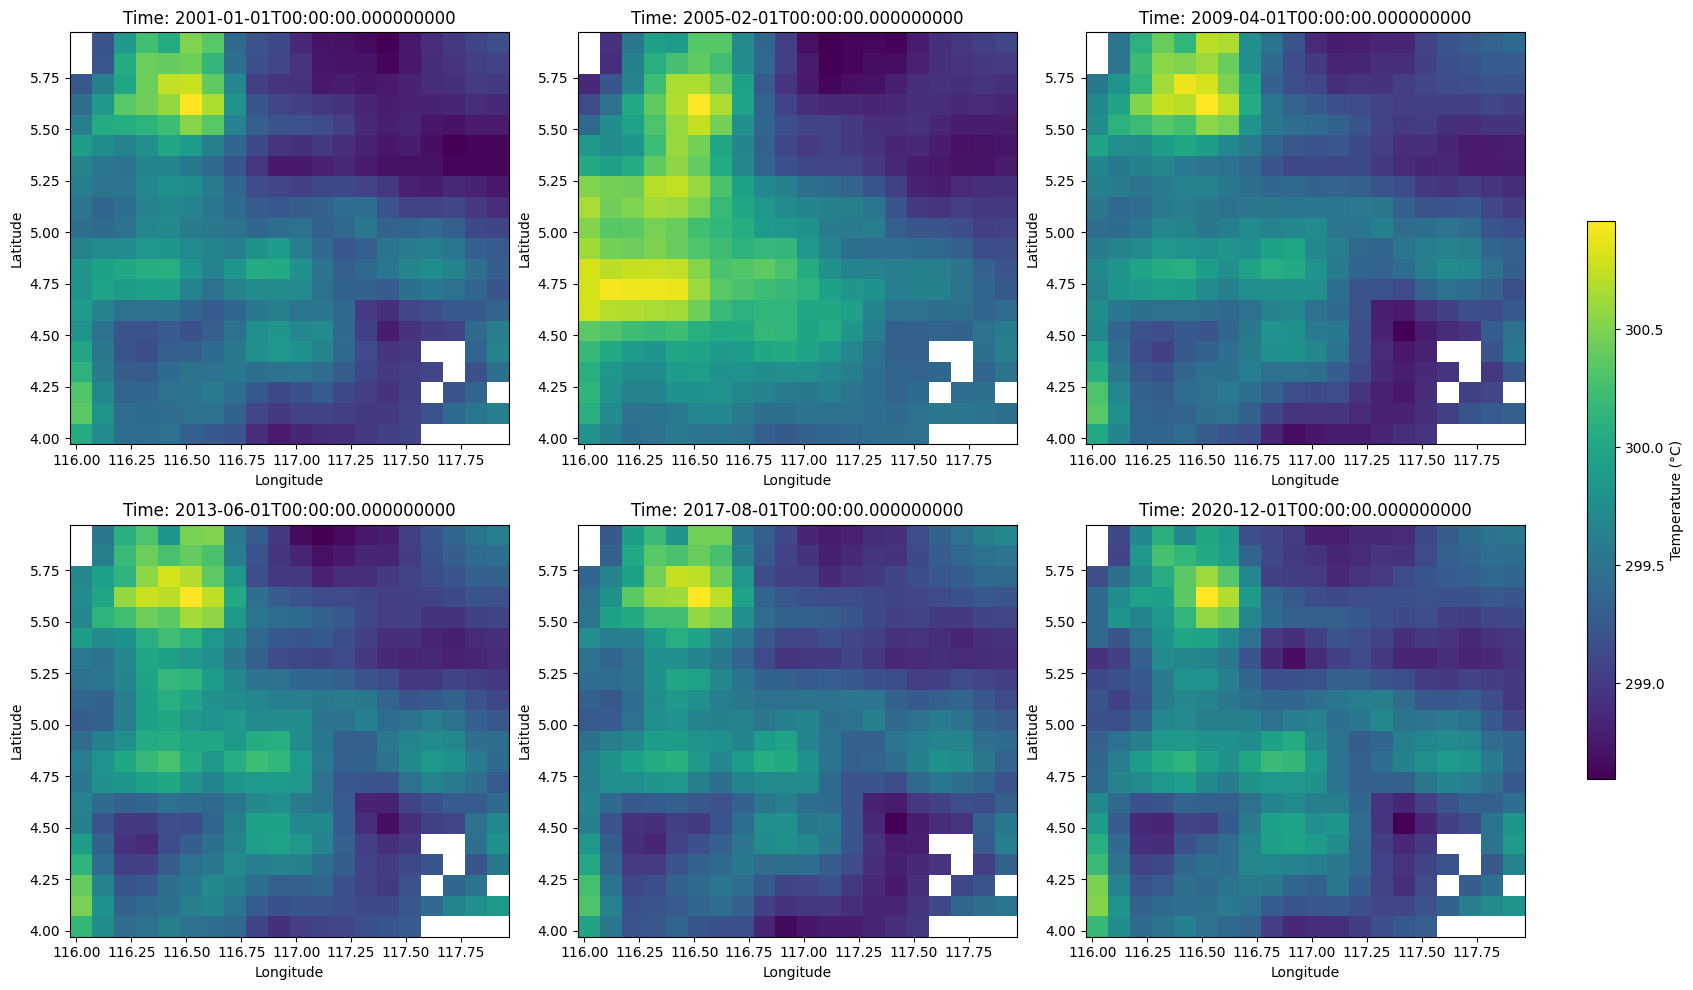

In [83]:
# Specified point in time
time_points = [1, 50, 100, 150, 200, 240]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for ax, t in zip(axs.flatten(), time_points):
    data = lowres_temperature_sealevel.isel(time=t-1)  
    im = ax.pcolormesh(data.longitude, data.latitude, data, cmap='viridis', shading='auto')  

    ax.set_title(f'Time: {data.time.values}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, label='Temperature (°C)')

plt.tight_layout()
plt.subplots_adjust(right=0.85) 
plt.show()

# Step 2: to interpolate temperature data to 100 m resolution using nearest neighbor

In [84]:
# Specify the original grid coordinates
lon = lowres_temperature['longitude'].values
lat = lowres_temperature['latitude'].values

# Define the desired grid resolution (1 km)
new_resolution = 1  # in km

# Convert the resolution to degrees
degree_per_km = 1 / 111.32  # approximate value for latitude
new_resolution_deg = new_resolution * degree_per_km
new_resolution_deg

0.008983111749910169

In [85]:
# Create a new grid of longitude and latitude coordinates with higher resolution

new_lon = np.arange(lon.min(), lon.max(), new_resolution_deg)
new_lat = np.arange(lat.max(), lat.min() , -new_resolution_deg)

# Create a meshgrid of the new longitude and latitude coordinates
new_lat_mesh, new_lon_mesh  = np.meshgrid(new_lat,new_lon)

In [86]:
# Create an empty array to store the interpolated temperature values
interpolated_temperature = np.empty((len(lowres_temperature['time']), len(new_lat), len(new_lon)))
interpolated_temperature.shape

(240, 212, 212)

In [87]:
lat_mesh, lon_mesh  = np.meshgrid(lat,lon)

In [88]:
print(f"Original lon range: {lon.min()} to {lon.max()}")
print(f"Original lat range: {lat.min()} to {lat.max()}")
print(f"New lon range: {new_lon.min()} to {new_lon.max()}")
print(f"New lat range: {new_lat.min()} to {new_lat.max()}")

Original lon range: 116.0199966430664 to 117.91999816894531
Original lat range: 4.019999980926514 to 5.920000076293945
New lon range: 116.0199966430664 to 117.91543322229806
New lat range: 4.024563497062851 to 5.920000076293945


In [89]:
original_points = np.array([lon_mesh.ravel(), lat_mesh.ravel()]).T
target_points = np.array([new_lon_mesh.ravel(), new_lat_mesh.ravel()]).T

In [90]:
# Interpolate temperature values for each time step
for i in range(len(lowres_temperature['time'])):
    temperature = lowres_temperature_sealevel.isel(time=i).values.ravel()
    global_mean = np.nanmean(temperature)
    temperature_filled = np.where(np.isnan(temperature), global_mean, temperature)
    # Fill NaN with global mean
    interpolated_values_flat = griddata(original_points, temperature_filled, target_points, method='cubic')
    
    # Storing the result
    interpolated_temperature[i, :, :] = interpolated_values_flat.reshape(new_lat_mesh.shape)
interpolated_temperature

array([[[298.84869365, 298.80635251, 298.76522494, ..., 298.58284979,
         298.59220577, 298.60157447],
        [298.85044778, 298.8080648 , 298.76609968, ..., 298.57250869,
         298.58131449, 298.59014919],
        [298.85211629, 298.81100426, 298.76942015, ..., 298.56220927,
         298.57046154, 298.57880635],
        ...,
        [299.71593926, 299.68198804, 299.64726031, ..., 298.92379577,
         298.92968676, 298.93832387],
        [299.67505607, 299.64318883, 299.61065898, ..., 298.89246081,
         298.89618175, 298.90187948],
        [299.63341666, 299.60344013, 299.57319513, ..., 298.85952871,
         298.86207537, 298.86546149]],

       [[298.9469551 , 298.89337317, 298.84106772, ..., 298.80639134,
         298.8165286 , 298.82667854],
        [298.95106389, 298.89757511, 298.84433292, ..., 298.78910439,
         298.79844114, 298.80782993],
        [298.95497214, 298.90309969, 298.85035399, ..., 298.77178989,
         298.78034219, 298.78912985],
        ...,


In [91]:
# Create a new xarray dataset for the interpolated temperature data
highres_sealevel_temperature = xr.Dataset(
    data_vars={'t2m': (['time', 'latitude', 'longitude'], interpolated_temperature)},
    coords={'time': lowres_temperature['time'], 'latitude': new_lat, 'longitude': new_lon}
)
highres_sealevel_temperature

<xarray.Dataset> Size: 86MB
Dimensions:    (time: 240, latitude: 212, longitude: 212)
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-01 2001-02-01 ... 2020-12-01
  * latitude   (latitude) float64 2kB 5.92 5.911 5.902 ... 4.043 4.034 4.025
  * longitude  (longitude) float64 2kB 116.0 116.0 116.0 ... 117.9 117.9 117.9
Data variables:
    t2m        (time, latitude, longitude) float64 86MB 298.8 298.8 ... 299.4

/var/folders/vq/91h3xwfn35s185lcs4zf91x80000gn/T/ipykernel_19993/193378409.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


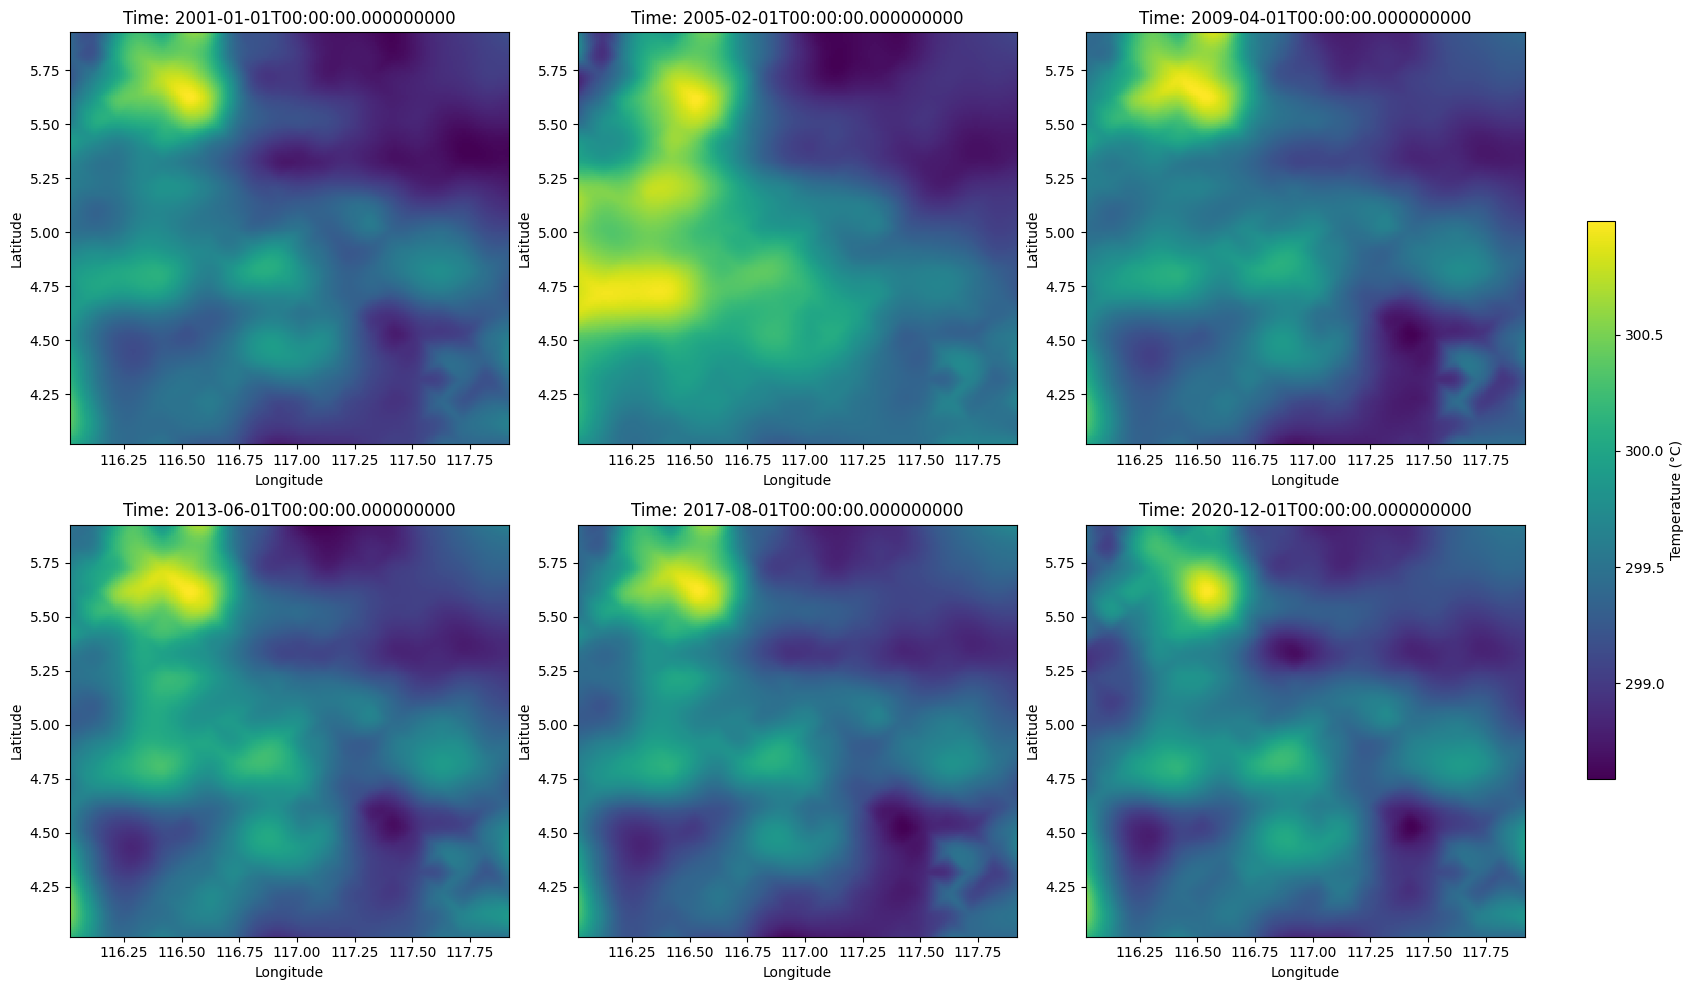

In [92]:
# Specified point in time
time_points = [1, 50, 100, 150, 200, 240]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

for ax, t in zip(axs.flatten(), time_points):
    data = highres_sealevel_temperature["t2m"].isel(time=t-1)  
    im = ax.pcolormesh(data.longitude, data.latitude, data, cmap='viridis', shading='auto')  

    ax.set_title(f'Time: {data.time.values}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

fig.colorbar(im, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, label='Temperature (°C)')

plt.tight_layout()
plt.subplots_adjust(right=0.85) 
plt.show()

# Step3: Interpolate temperature to high resolution new elevation

In [93]:
# open GeoTIFF file
with rasterio.open('high_geopotential.tif') as src:
    # Read the first band for basic visualization
    band1 = src.read(1)
    
    # Collect file properties and transformation information
    data_type = band1.dtype
    file_width = src.width
    file_height = src.height
    num_bands = src.count
    crs = src.crs
    transform_info = src.transform

(data_type, file_width, file_height, num_bands, crs, transform_info)
#Each pixel represents approximately 0.00027778 degrees on the ground. 
#In a geographic coordinate system, this usually means that each pixel equals approximately 30.87 meters (depending on latitude).

(dtype('int16'),
 6840,
 6840,
 1,
 CRS.from_epsg(4326),
 Affine(0.0002777777777778146, 0.0, 116.0198611111503,
        0.0, -0.0002777777777778146, 5.9201388888817235))

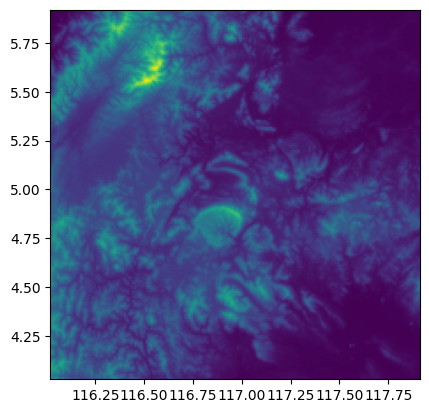

<Axes: >

In [94]:
import rasterio
from rasterio.features import geometry_mask
from rasterio.warp import reproject, Resampling
from rasterio.plot import show
from shapely.geometry import box
import numpy as np

# Define the bounding box coordinates
min_lon = 116.02
min_lat = 4.02
max_lon = 117.92
max_lat = 5.92
bbox = box(min_lon, min_lat, max_lon, max_lat)

file_path = 'high_geopotential.tif'
clipped_file_path = 'clipped_geopotential.tif'
reprojected_file_path = 'reprojected_geopotential.tif'

# Open the original GeoTIFF file and clip it
with rasterio.open(file_path) as src:
    mask = geometry_mask([bbox], transform=src.transform, invert=True, out_shape=(src.height, src.width))
    out_image = src.read(1) * mask
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff", "height": out_image.shape[0], "width": out_image.shape[1], "transform": src.transform})

    # Save the clipped image to a new file
    with rasterio.open(clipped_file_path, 'w', **out_meta) as dest:
        dest.write(out_image, 1)

# Define the new resolution in degrees (assuming 100m resolution desired)
meters_per_degree = 111000
resolution_meters = 1000
resolution_degrees = resolution_meters / meters_per_degree

# Reproject the clipped image to the new resolution
with rasterio.open(clipped_file_path) as src:
    original_image = src.read(1, masked=True)
    original_transform = src.transform
    new_width = int((max_lon - min_lon) / resolution_degrees)
    new_height = int((max_lat - min_lat) / resolution_degrees)
    affine_transform = rasterio.transform.from_origin(min_lon, max_lat, resolution_degrees, resolution_degrees)
    reprojected_image = np.zeros((new_height, new_width), dtype=original_image.dtype)

    reproject(original_image, reprojected_image,
              src_transform=original_transform,
              dst_transform=affine_transform,
              src_crs=src.crs,
              dst_crs=src.crs,
              resampling=Resampling.bilinear)

    reprojected_meta = src.meta.copy()
    reprojected_meta.update({"driver": "GTiff", "height": reprojected_image.shape[0], "width": reprojected_image.shape[1], "transform": affine_transform, "crs": src.crs})
    with rasterio.open(reprojected_file_path, 'w', **reprojected_meta) as dest:
        dest.write(reprojected_image, 1)
# Display the reprojected image
show(reprojected_image, transform=affine_transform)


In [95]:
with rasterio.open(reprojected_file_path) as src:
    data = src.read(1)
    transform = src.transform

    lons = np.linspace(transform.c, transform.c + transform.a * (src.width - 1), src.width)
    lats = np.linspace(transform.f, transform.f + transform.e * (src.height - 1), src.height)

    time = pd.Timestamp('2020-01-01')

    data_array = xr.DataArray(
        data[np.newaxis, ...], 
        dims=("time", "latitude", "longitude"),
        coords={
            "time": [time],
            "latitude": lats,
            "longitude": lons
        },
        name="geopotential"
    )

    high_res_geopotential = data_array.to_dataset()

high_res_geopotential

<xarray.Dataset> Size: 92kB
Dimensions:       (time: 1, latitude: 210, longitude: 210)
Coordinates:
  * time          (time) datetime64[ns] 8B 2020-01-01
  * latitude      (latitude) float64 2kB 5.92 5.911 5.902 ... 4.055 4.046 4.037
  * longitude     (longitude) float64 2kB 116.0 116.0 116.0 ... 117.9 117.9
Data variables:
    geopotential  (time, latitude, longitude) int16 88kB 0 0 3 8 8 ... 6 3 0 0 0

In [96]:
# Interpolate high_res_geopotential data onto a highres_sealevel_temperature latitude and longitude grid
high_res_geopotential= high_res_geopotential.interp(
    latitude=highres_sealevel_temperature['latitude'],
    longitude=highres_sealevel_temperature['longitude'],
    method='linear'  # Select the interpolation method, 'linear' is one of the commonly used interpolation methods
)
high_res_geopotential

<xarray.Dataset> Size: 363kB
Dimensions:       (time: 1, latitude: 212, longitude: 212)
Coordinates:
  * time          (time) datetime64[ns] 8B 2020-01-01
  * latitude      (latitude) float64 2kB 5.92 5.911 5.902 ... 4.043 4.034 4.025
  * longitude     (longitude) float64 2kB 116.0 116.0 116.0 ... 117.9 117.9
Data variables:
    geopotential  (time, latitude, longitude) float64 360kB nan nan ... nan nan

In [97]:
#high_res_altitude = (high_res_geopotential * earth_radius) / (gravity * earth_radius - high_res_geopotential)
#high_res_altitude

In [98]:
#highres_sealevel_temperature

In [99]:
# Calculate temperature as high resolution elevation
highres_temperature = highres_sealevel_temperature['t2m'].values + (high_res_geopotential['geopotential'].values * lapse_rate)
highres_temperature = xr.DataArray(
    highres_temperature,
    dims=['time','latitude','longitude'],
    coords={
        'time': highres_sealevel_temperature.time,
        'latitude': highres_sealevel_temperature.latitude,
        'longitude': highres_sealevel_temperature.longitude
    }
)
highres_temperature

<xarray.DataArray (time: 240, latitude: 212, longitude: 212)> Size: 86MB
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 298.80210152, 298.71249679, ..., 298.48124974,
                  nan,          nan],
        [         nan, 298.79907766, 298.72160641, ..., 298.45189199,
                  nan,          nan],
        ...,
        [         nan, 293.26861233, 293.71576668, ..., 298.88053825,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 298.89161183, 298.79073003, ..., 298.69784544,
                  nan,          nan],
        [         nan, 298.89117309, 298.80254025, ..., 298.6614726 ,
                  nan,          nan],
...
        [         nan, 293.80905466, 294.25197665, ..., 299.45070761,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan, 299.36877341, 299.27062047, ..., 299.43134373,
                  nan,          nan],
        [         nan, 299.36820922, 299.28150269, ..., 299.40167614,
                  nan,          nan],
        ...,
        [         nan, 293.82395158, 294.26383142, ..., 299.49494907,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2kB 2001-01-01 2001-02-01 ... 2020-12-01
  * latitude   (latitude) float64 2kB 5.92 5.911 5.902 ... 4.043 4.034 4.025
  * longitude  (longitude) float64 2kB 116.0 116.0 116.0 ... 117.9 117.9 117.9

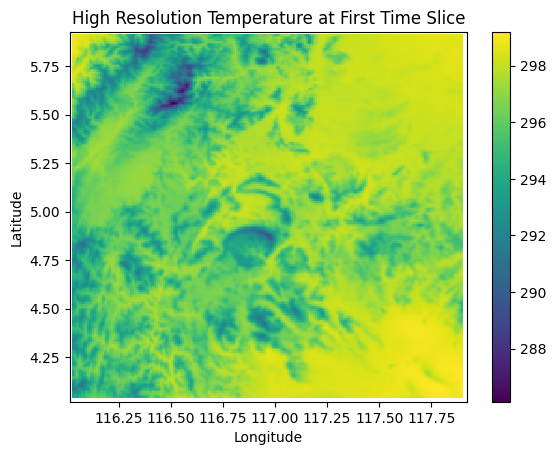

In [100]:
temperature_slice = highres_temperature.isel(time=1)

# Use xarray's plotting function which handles the colorbar automatically
p = temperature_slice.plot(cmap='viridis')  # 'p' is the mappable (image or contour set) returned by .plot()

# Enhance the plot with titles and labels
plt.title('High Resolution Temperature at First Time Slice')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Step4: Load and clean measurement data

In [101]:
file_id = ['A_586', 'A_587', 'A_588', 'A_590', 'A_591', 'A_592', 'A_593', 'A_594', 'B_600', 'B_602', 'B_605', 'B_607', 'B_608', 'B_609', 'B_610', 'B_611', 'C_617', 'C_619', 'C_620', 'C_621', 'C_622', 'C_623', 'C_624', 'C_625', 'D_632', 'D_633', 'D_636', 'D_637', 'D_638', 'E_648', 'E_656', 'E_657', 'E_659', 'F_672', 'F_674', 'LFE_705', 'LFE_706', 'LFE_708', 'LFE_710', 'OG1_714', 'OG1_717', 'OG1_718', 'OG1_719', 'OG2_720', 'RP_5m_A0', 'RP_5m_B0']
def process_temperature_data(file_id, latitude, longitude):
    # Load temperature data from an Excel file
    file_path = f"{file_id}.xlsx"
    try:
        temp_data = pd.read_excel(file_path)
        temp_data['time'] = pd.to_datetime(temp_data['time'])
        temp_data.set_index('time', inplace=True)
        
        # Calculate monthly average temperature
        monthly_avg_temp = temp_data['Temp'].resample('M').mean()
        
        # Remove any months with NaN values
        monthly_avg_temp_clean = monthly_avg_temp.dropna()
        
        # Select the nearest temperature model data point
        nearest_model_temp = highres_temperature.sel(latitude=latitude, longitude=longitude, method="nearest")
        
        return monthly_avg_temp_clean, nearest_model_temp
    
    except Exception as e:
        return str(e)

In [102]:

location_data = pd.read_excel("/Users/yangcan/Desktop/master project/data/latitude_longitude_data.xlsx")


results = {}  
for index, row in location_data.iterrows():
    file_id = row['ID']
    latitude = row['Latitude']
    longitude = row['Longitude']
    

    measure, model = process_temperature_data(file_id, latitude, longitude)
    

    results[file_id] = {
        'Measure': measure,
        'Model': model
    }

/var/folders/vq/91h3xwfn35s185lcs4zf91x80000gn/T/ipykernel_19993/3065505139.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_temp = temp_data['Temp'].resample('M').mean()
/var/folders/vq/91h3xwfn35s185lcs4zf91x80000gn/T/ipykernel_19993/3065505139.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_temp = temp_data['Temp'].resample('M').mean()
/var/folders/vq/91h3xwfn35s185lcs4zf91x80000gn/T/ipykernel_19993/3065505139.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_temp = temp_data['Temp'].resample('M').mean()
/var/folders/vq/91h3xwfn35s185lcs4zf91x80000gn/T/ipykernel_19993/3065505139.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_temp = temp_data['Temp'].resample('M').mean()
/var/folders/vq/91h3xwfn35s185lc

In [103]:

for file_id in results:

    globals()[f"{file_id}_model"] = results[file_id]['Model']
    globals()[f"{file_id}_measure"] = results[file_id]['Measure']

In [104]:

time_ranges = [
    slice("2013-05-01", "2015-10-31"),
    slice("2018-11-01", "2018-11-30"),
    slice("2018-12-01", "2018-12-31"),
    slice("2019-01-01", "2019-01-31")
]


selected_data = xr.concat(
    [A_586_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)

A_586_model = selected_data - 273.15
A_586_model

<xarray.DataArray (time: 33)> Size: 264B
array([24.50996843, 24.75520077, 23.95548714, 23.92463493, 24.35995186,
       24.27412967, 23.70215482, 24.00618697, 23.14348869, 23.70184796,
       24.54807033, 24.8107382 , 24.70123142, 24.79598441, 24.53873673,
       23.89176064, 24.18484142, 24.45212506, 24.04373347, 24.03782951,
       23.57760233, 23.9359681 , 24.4183967 , 24.76058688, 24.80865147,
       24.59362173, 24.63154005, 24.49711664, 24.53845883, 24.55207258,
       24.29962524, 24.28852132, 23.99459406])
Coordinates:
  * time       (time) datetime64[ns] 264B 2013-05-01 2013-06-01 ... 2019-01-01
    latitude   float64 8B 4.707
    longitude  float64 8B 117.7

In [105]:
#A_587
time_ranges = [
    slice("2013-05-01", "2015-10-31"),
    slice("2018-11-01", "2018-11-30"),
    slice("2018-12-01", "2018-12-31"),
    slice("2019-01-01", "2019-01-31")
]
selected_data = xr.concat(
    [A_587_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
A_587_model = selected_data - 273.15

In [106]:
#A_588
time_ranges = [
    slice("2013-05-01", "2015-10-31"),
    slice("2018-11-01", "2018-11-30"),
    slice("2018-12-01", "2018-12-31"),
    slice("2019-01-01", "2019-01-31")
]
selected_data = xr.concat(
    [A_588_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
A_588_model = selected_data - 273.15
#A_590
time_ranges = [
    slice("2013-05-01", "2015-10-31"),
    slice("2018-11-01", "2018-11-30"),
    slice("2018-12-01", "2018-12-31"),
    slice("2019-01-01", "2019-01-31")
]
selected_data = xr.concat(
    [A_590_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
A_590_model = selected_data - 273.15
#A_591
time_ranges = [
    slice("2013-05-01", "2013-08-31"),
    slice("2014-05-01", "2014-07-31"),
    slice("2015-02-01", "2015-03-31"),
    slice("2018-11-01", "2019-01-31")
]
selected_data = xr.concat(
    [A_591_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
A_591_model = selected_data - 273.15
#A_592
time_ranges = [
    slice("2013-05-01", "2014-02-28"),
    slice("2014-05-01", "2014-06-30"),
    slice("2015-02-01", "2015-03-31"),
    slice("2016-08-01", "2016-09-30"),
    slice("2018-11-01", "2019-01-31")
]
selected_data = xr.concat(
    [A_592_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
A_592_model = selected_data - 273.15
#A_593
time_ranges = [
    slice("2013-05-01", "2015-11-30"),
    slice("2018-11-01", "2019-01-31")
]
selected_data = xr.concat(
    [A_593_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
A_593_model = selected_data - 273.15
#A_594
time_ranges = [
    slice("2013-05-01", "2015-07-31")
]
selected_data = xr.concat(
    [A_594_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
A_594_model = selected_data - 273.15
#B_600
time_ranges = [
    slice("2014-04-01", "2015-10-31")
]
selected_data = xr.concat(
    [B_600_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_600_model = selected_data - 273.15
#B_602
time_ranges = [
    slice("2014-04-01", "2015-10-31")
]
selected_data = xr.concat(
    [B_602_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_602_model = selected_data - 273.15
#B_605
time_ranges = [
    slice("2014-05-01", "2015-06-30"),
    slice("2018-02-01", "2019-09-30")
]
selected_data = xr.concat(
    [B_605_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_605_model = selected_data - 273.15
#B_607
time_ranges = [
    slice("2014-05-01", "2015-10-31"),
    slice("2016-08-01", "2017-05-31"),
    slice("2018-02-01", "2018-02-28")
]
selected_data = xr.concat(
    [B_607_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_607_model = selected_data - 273.15
#B_608
time_ranges = [
    slice("2014-04-01", "2015-10-31")
]
selected_data = xr.concat(
    [B_608_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_608_model = selected_data - 273.15
#B_609
time_ranges = [
    slice("2014-04-01", "2015-01-31")
]
selected_data = xr.concat(
    [B_609_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_609_model = selected_data - 273.15
#B_610
time_ranges = [
    slice("2014-04-01", "2015-10-31")
]
selected_data = xr.concat(
    [B_610_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_610_model = selected_data - 273.15
#B_611
time_ranges = [
    slice("2014-04-01", "2014-05-31")
]
selected_data = xr.concat(
    [B_611_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
B_611_model = selected_data - 273.15
#C_617    
time_ranges = [
    slice("2013-05-01", "2013-07-31"),
    slice("2014-02-01", "2014-04-30"),
    slice("2015-01-01", "2015-02-28"),
]
selected_data = xr.concat(
    [C_617_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_617_model = selected_data - 273.15
#C_619      
time_ranges = [
    slice("2013-05-01", "2014-11-30"),
    slice("2015-03-01", "2015-08-31"),
    slice("2016-08-01", "2017-04-30")
]
selected_data = xr.concat(
    [C_619_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_619_model = selected_data - 273.15
#C_620  
time_ranges = [
    slice("2013-05-01", "2013-06-30"),
    slice("2014-02-01", "2014-04-30"),
    slice("2015-01-01", "2015-03-31"),
    slice("2016-08-01", "2016-08-31")
]
selected_data = xr.concat(
    [C_620_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_620_model = selected_data - 273.15
#C_621
time_ranges = [
    slice("2013-05-01", "2013-12-31"),
    slice("2014-02-01", "2014-03-31"),
]
selected_data = xr.concat(
    [C_621_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_621_model = selected_data - 273.15
#C_622
time_ranges = [
    slice("2013-05-01", "2014-06-30"),
    slice("2015-01-01", "2015-01-31")
]
selected_data = xr.concat(
    [C_622_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_622_model = selected_data - 273.15
#C_623
time_ranges = [
    slice("2013-05-01", "2015-01-31"),
]
selected_data = xr.concat(
    [C_623_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_623_model = selected_data - 273.15
#C_624
time_ranges = [
    slice("2013-05-01", "2015-11-30"),
]
selected_data = xr.concat(
    [C_624_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_624_model = selected_data - 273.15
#C_625
time_ranges = [
    slice("2013-05-01", "2015-11-30"),
]
selected_data = xr.concat(
    [C_625_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
C_625_model = selected_data - 273.15
#D_632
time_ranges = [
    slice("2013-05-01", "2014-11-30"),
    slice("2015-01-01", "2015-11-30"),
]
selected_data = xr.concat(
    [D_632_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
D_632_model = selected_data - 273.15
#D_633
time_ranges = [
    slice("2013-05-01", "2013-10-31"),
    slice("2014-02-01", "2014-04-30"),
    slice("2015-01-01", "2015-02-28"),
]
selected_data = xr.concat(
    [D_633_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
D_633_model = selected_data - 273.15
#D_636
time_ranges = [
    slice("2013-05-01", "2013-08-31"),
    slice("2014-02-01", "2014-05-31"),
    slice("2015-01-01", "2015-04-30"),
    slice("2016-08-01", "2016-09-30")
]
selected_data = xr.concat(
    [D_636_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
D_636_model = selected_data - 273.15
#D_637
time_ranges = [
    slice("2013-05-01", "2013-11-30"),
    slice("2014-02-01", "2014-09-30"),
    slice("2015-01-01", "2015-02-28"),
    slice("2016-08-01", "2016-09-30")
]
selected_data = xr.concat(
    [D_637_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
D_637_model = selected_data - 273.15
#D_638
time_ranges = [
    slice("2013-05-01", "2014-11-30"),
    slice("2015-01-01", "2015-11-30"),
    slice("2016-08-01", "2017-01-31")
]
selected_data = xr.concat(
    [D_638_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
D_638_model = selected_data - 273.15
#E_648
time_ranges = [
    slice("2013-11-01", "2015-01-31"),
    slice("2016-09-01", "2017-04-30"),
    slice("2019-01-01", "2019-03-31")
]
selected_data = xr.concat(
    [E_648_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
E_648_model = selected_data - 273.15
#E_656
time_ranges = [
    slice("2013-11-01", "2014-02-28"),
    slice("2016-09-01", "2017-04-30")
]
selected_data = xr.concat(
    [E_656_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
E_656_model = selected_data - 273.15
#E_657
time_ranges = [
    slice("2013-11-01", "2014-05-31"),
    slice("2015-01-01", "2015-11-30"),
    slice("2016-09-01", "2017-04-30"),
    slice("2018-02-01", "2019-03-31")
]
selected_data = xr.concat(
    [E_657_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
E_657_model = selected_data - 273.15
#E_659
time_ranges = [
    slice("2013-11-01", "2014-05-31"),
    slice("2015-01-01", "2015-11-30"),
    slice("2016-09-01", "2017-04-30"),
    slice("2019-01-01", "2019-03-31")
]
selected_data = xr.concat(
    [E_659_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
E_659_model = selected_data - 273.15
#F_672
time_ranges = [
    slice("2013-05-01", "2018-09-30")
]
selected_data = xr.concat(
    [F_672_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
F_672_model = selected_data - 273.15
#F_674
time_ranges = [
    slice("2013-05-01", "2015-01-31"),
    slice("2016-04-01", "2017-08-31"),
    slice("2018-07-01", "2018-09-30")
]
selected_data = xr.concat(
    [F_674_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
F_674_model = selected_data - 273.15
#LFE_705
time_ranges = [
    slice("2015-01-01", "2015-11-30"),
    slice("2016-08-01", "2017-01-31"),
    slice("2018-02-01", "2018-09-30")
]
selected_data = xr.concat(
    [LFE_705_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
LFE_705_model = selected_data - 273.15
#LFE_706
time_ranges = [
    slice("2013-06-01", "2015-11-30"),
    slice("2016-08-01", "2017-01-31"),
    slice("2018-02-01", "2018-09-30")
]
selected_data = xr.concat(
    [LFE_706_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
LFE_706_model = selected_data - 273.15
#LFE_708
time_ranges = [
    slice("2013-06-01", "2015-01-31"),
    slice("2016-08-01", "2017-01-31"),
    slice("2018-02-01", "2018-09-30")
]
selected_data = xr.concat(
    [LFE_708_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
LFE_708_model = selected_data - 273.15
#LFE_710
time_ranges = [
    slice("2013-06-01", "2014-09-30"),
    slice("2015-01-01", "2015-11-30"),
    slice("2016-08-01", "2017-01-31"),
    slice("2018-02-01", "2018-09-30")
]
selected_data = xr.concat(
    [LFE_710_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
LFE_710_model = selected_data - 273.15
#OG1_714
time_ranges = [
    slice("2013-07-01", "2017-02-28")
]
selected_data = xr.concat(
    [OG1_714_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
OG1_714_model = selected_data - 273.15
#OG1_717
time_ranges = [
    slice("2013-11-01", "2014-11-30"),
    slice("2015-01-01", "2017-02-28"),
]
selected_data = xr.concat(
    [OG1_717_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
OG1_717_model = selected_data - 273.15
#OG1_718
time_ranges = [
    slice("2013-07-01", "2017-02-28")
]
selected_data = xr.concat(
    [OG1_718_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
OG1_718_model = selected_data - 273.15
#OG1_719
time_ranges = [
    slice("2013-11-01", "2014-09-30"),
    slice("2015-01-01", "2015-04-30"),
    slice("2015-12-01", "2015-12-31")
]
selected_data = xr.concat(
    [OG1_719_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
OG1_719_model = selected_data - 273.15
#OG2_720
time_ranges = [
    slice("2013-07-01", "2015-12-31"),
    slice("2016-12-01", "2017-03-31")
]
selected_data = xr.concat(
    [OG2_720_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
OG2_720_model = selected_data - 273.15
#RP_5m_A0
time_ranges = [
    slice("2013-06-01", "2017-03-31")
]
selected_data = xr.concat(
    [RP_5m_A0_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
RP_5m_A0_model = selected_data - 273.15
#RP_5m_B0
time_ranges = [
    slice("2013-06-01", "2017-03-31")
]
selected_data = xr.concat(
    [RP_5m_B0_model.sel(time=tr) for tr in time_ranges],
    dim='time'
)
RP_5m_B0_model = selected_data - 273.15


In [107]:
model = {'A_586_model': A_586_model,'A_587_model': A_587_model,"A_587_model": A_587_model,"A_588_model": A_588_model,"A_590_model": A_590_model,"A_591_model": A_591_model,"A_592_model": A_592_model,"A_593_model": A_593_model,"A_594_model": A_594_model,"B_600_model": B_600_model,"B_602_model": B_602_model,"B_605_model": B_605_model,"B_607_model": B_607_model,"B_608_model": B_608_model,"B_609_model": B_609_model,"B_610_model": B_610_model,"B_611_model": B_611_model,"C_617_model": C_617_model,"C_619_model": C_619_model,"C_620_model": C_620_model,"C_621_model": C_621_model,"C_622_model": C_622_model,"C_623_model": C_623_model,"C_624_model": C_624_model,"C_625_model": C_625_model,"D_632_model": D_632_model,"D_633_model": D_633_model,"D_636_model": D_636_model,"D_637_model": D_637_model,"D_638_model": D_638_model,"E_648_model": E_648_model,"E_656_model": E_656_model,"E_657_model": E_657_model,"E_659_model": E_659_model,"F_672_model": F_672_model,"F_674_model": F_674_model,"LFE_705_model": LFE_705_model,"LFE_706_model": LFE_706_model,"LFE_708_model": LFE_708_model,"LFE_710_model": LFE_710_model,"OG1_714_model": OG1_714_model,"OG1_717_model": OG1_717_model,"OG1_718_model": OG1_718_model,"OG1_719_model": OG1_719_model,"OG2_720_model": OG2_720_model,"RP_5m_A0_model": RP_5m_A0_model,"RP_5m_B0_model": RP_5m_B0_model}
measure = {"A_586_measure": A_586_measure,"A_587_measure": A_587_measure,"A_587_measure": A_587_measure,"A_588_measure": A_588_measure,"A_590_measure": A_590_measure,"A_591_measure": A_591_measure,"A_592_measure": A_592_measure,"A_593_measure": A_593_measure,"A_594_measure": A_594_measure,"B_600_measure": B_600_measure,"B_602_measure": B_602_measure,"B_605_measure": B_605_measure,"B_607_measure": B_607_measure,"B_608_measure": B_608_measure,"B_609_measure": B_609_measure,"B_610_measure": B_610_measure,"B_611_measure": B_611_measure,"C_617_measure": C_617_measure,"C_619_measure": C_619_measure,"C_620_measure": C_620_measure,"C_621_measure": C_621_measure,"C_622_measure": C_622_measure,"C_623_measure": C_623_measure,"C_624_measure": C_624_measure,"C_625_measure": C_625_measure,"D_632_measure": D_632_measure,"D_633_measure": D_633_measure,"D_636_measure": D_636_measure,"D_637_measure": D_637_measure,"D_638_measure": D_638_measure,"E_648_measure": E_648_measure,"E_656_measure": E_656_measure,"E_657_measure": E_657_measure,"E_659_measure": E_659_measure,"F_672_measure": F_672_measure,"F_674_measure": F_674_measure,"LFE_705_measure": LFE_705_measure,"LFE_706_measure": LFE_706_measure,"LFE_708_measure": LFE_708_measure,"LFE_710_measure": LFE_710_measure,"OG1_714_measure": OG1_714_measure,"OG1_717_measure": OG1_717_measure,"OG1_718_measure": OG1_718_measure,"OG1_719_measure": OG1_719_measure,"OG2_720_measure": OG2_720_measure,"RP_5m_A0_measure": RP_5m_A0_measure,"RP_5m_B0_measure": RP_5m_B0_measure}

In [144]:

lat_lon_list = []

for model_name, model_data in model.items():
    lat_vals = model_data['latitude'].values.flatten()
    lon_vals = model_data['longitude'].values.flatten()
    lat_lon_pairs = zip(lat_vals, lon_vals)
    lat_lon_list.extend(lat_lon_pairs)

lat_lon_df = pd.DataFrame(lat_lon_list, columns=['Latitude', 'Longitude'])

lat_lon_df
lat_lon_df.to_csv('1km_lon_lat.csv', index=False)


In [108]:

for key in model:
    temp_df = model[key].to_dataframe(name='value')

    temp_df.index = temp_df.index.get_level_values('time').strftime('%Y-%m')
    

    globals()[key] = temp_df
for key in measure:

    temp_df = measure[key].to_frame(name='value')

    temp_df.index = temp_df.index.strftime('%Y-%m')
    
    globals()[key] = temp_df


In [109]:
def prepare_model_data(model_dict):
    new_model_dict = {}
    for key, data in model_dict.items():
        temp_df = data.to_dataframe(name='value')
        temp_df.index = temp_df.index.get_level_values('time').strftime('%Y-%m')
        new_model_dict[key] = temp_df
    return new_model_dict
def prepare_measure_data(measure_dict):
    new_measure_dict = {}
    for key, data in measure_dict.items():
        temp_df = data.to_frame(name='value')
        temp_df.index = temp_df.index.strftime('%Y-%m')
        new_measure_dict[key] = temp_df
    return new_measure_dict

new_model_9 = prepare_model_data(model)
new_measure = prepare_measure_data(measure)

In [110]:
for key, df in new_model_9.items():
    df.to_csv(f'{key}_1.csv')